In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.sersic_functions import sersic_profile, generate_random_pos
from utils.custom_datasets import recenter_on_sn

In [2]:
df = pd.read_csv("..\data\SERSIC\delight_sersic.csv", dtype={'objID': 'Int64'})

sn_pos = df[["dx","dy"]].values.astype(np.float32)
sersic_radius = df["rSerRadius"].values.astype(np.float32)
sersic_ab = df["rSerAb"].values.astype(np.float32)
sersic_phi = df["rSerPhi"].values.astype(np.float32)

oid_train = np.load(f"..\data\SERSIC\id_train.npy",allow_pickle=True) 
idx_train = df[df['oid'].isin(oid_train)].index.to_numpy()

X_train_autolabeling = np.load("..\data\SERSIC\X_train_autolabeling.npy")
y_train = sn_pos[idx_train]

mask_radius_10 = (df["rSerRadius"].values[idx_train] < 9.8)

df_train = df.iloc[idx_train][mask_radius_10]
X_train_autolabeling = X_train_autolabeling[mask_radius_10]

y_train = y_train[mask_radius_10]

train_sersic_radius = sersic_radius[idx_train][mask_radius_10]
train_sersic_ab = sersic_ab[idx_train][mask_radius_10]
train_sersic_phi = sersic_phi[idx_train][mask_radius_10]

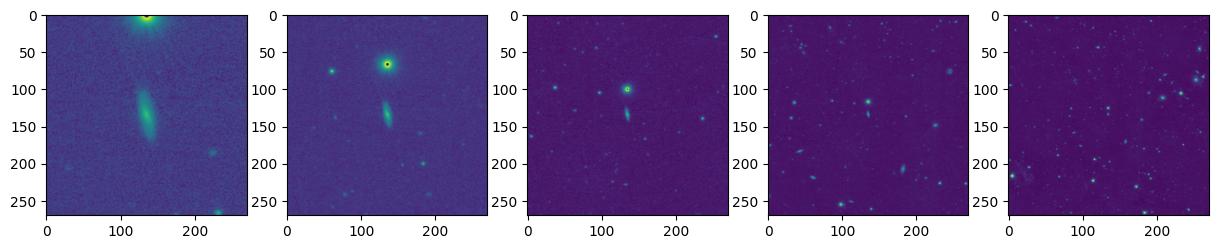

In [7]:
# Veamos un ejemplo

idx = 17 
image = X_train_autolabeling[idx]

fig, axs = plt.subplots(1,5, figsize= (15,5))

for i in range(5):
    axs[i].imshow(image[:,:,i])

plt.show()

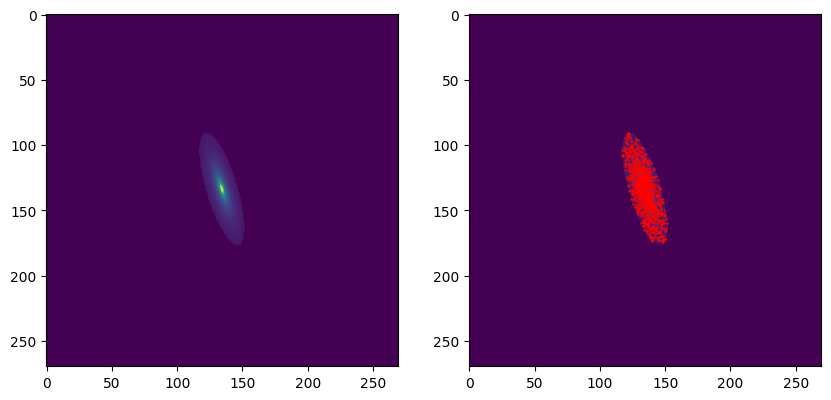

In [30]:
# Veamos su perfil de sersic y generemos en base al perfil algunas posiciones arbitrarias

sersic_img = sersic_profile(
    image_shape=(270,270),
    x_center=134, y_center=134,
    Re_arcsec=train_sersic_radius[idx],
    b_over_a=train_sersic_ab[idx],
    theta_deg=train_sersic_phi[idx],  
    pixel_scale=0.25,
    Ie=1,
    n=4
)

random_pos = []
for i in range(1000):
    pos = generate_random_pos(sersic_radius = train_sersic_radius[idx], 
                                sersic_ab = train_sersic_ab[idx], 
                                sersic_phi =train_sersic_phi[idx], 
                                img_size = image.shape[0])
    random_pos.append(pos) 

random_pos =  np.array(random_pos) + 134
x_pos = random_pos[:, 1] # Delight usa el target de la forma (y,x)
y_pos = random_pos[:, 0]


fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].imshow(sersic_img, vmax=200, vmin=0)
axs[1].imshow(sersic_img, vmax=200, vmin=0)
axs[1].scatter(x_pos, y_pos, s=0.5, color="red")

plt.show()

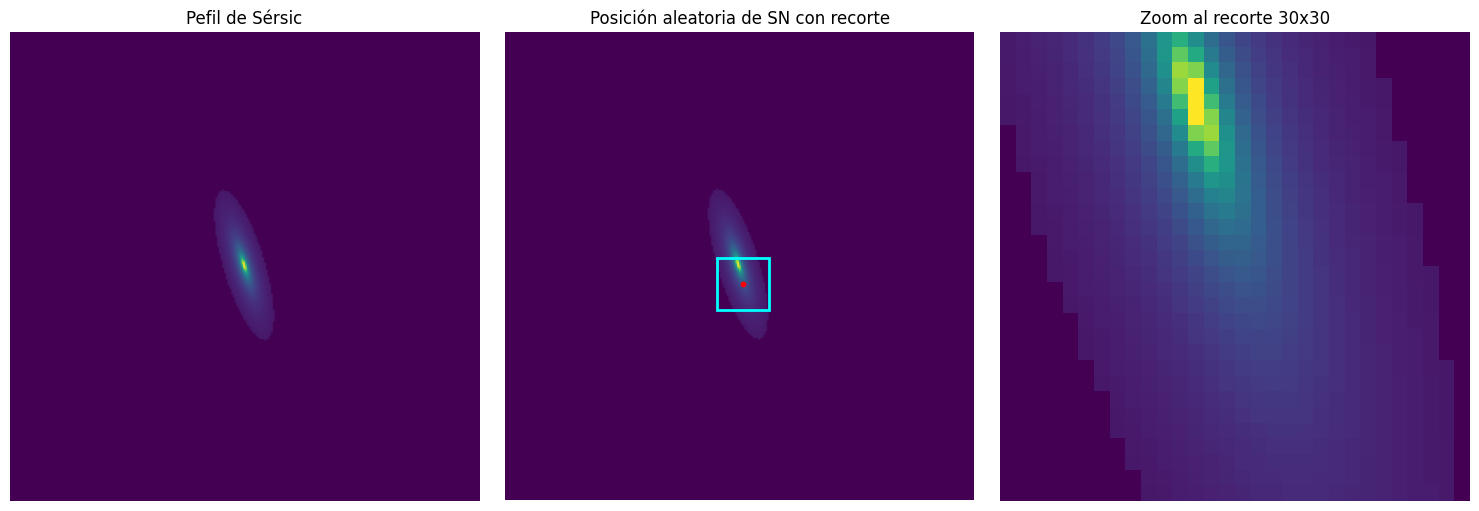

In [ ]:
# Ahora generemos el recorte en 1 posicion arbitraria


sersic_img = sersic_profile(
    image_shape=(270, 270),
    x_center=134, y_center=134,
    Re_arcsec=train_sersic_radius[idx],
    b_over_a=train_sersic_ab[idx],
    theta_deg=train_sersic_phi[idx],  
    pixel_scale=0.25,
    Ie=1,
    n=4
)

# Posición arbitraria
pos = generate_random_pos(
    sersic_radius=train_sersic_radius[idx], 
    sersic_ab=train_sersic_ab[idx], 
    sersic_phi=train_sersic_phi[idx], 
    img_size=sersic_img.shape[0]
)

x_pos = int(pos[1] + 134)
y_pos = int(pos[0] + 134)
side = 30
half = side // 2

# Cuadro
square = Rectangle(
    (x_pos - half, y_pos - half),
    width=side,
    height=side,
    edgecolor='cyan',
    facecolor='none',
    linewidth=2
)

# Recorte 
x_min = max(0, x_pos - half)
x_max = min(sersic_img.shape[1], x_pos + half)
y_min = max(0, y_pos - half)
y_max = min(sersic_img.shape[0], y_pos + half)
zoom_crop = sersic_img[y_min:y_max, x_min:x_max]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sersic_img, vmax=200, vmin=0)
axs[0].set_title("Pefil de Sérsic")

axs[1].imshow(sersic_img, vmax=200, vmin=0)
axs[1].scatter(x_pos, y_pos, s=10, color="red")
axs[1].add_patch(square)
axs[1].set_title("Posición aleatoria de SN con recorte")
axs[1].set_xlim(0, 270)
axs[1].set_ylim(270, 0)

axs[2].imshow(zoom_crop, vmax=200, vmin=0)
axs[2].set_title("Zoom al recorte 30x30")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()

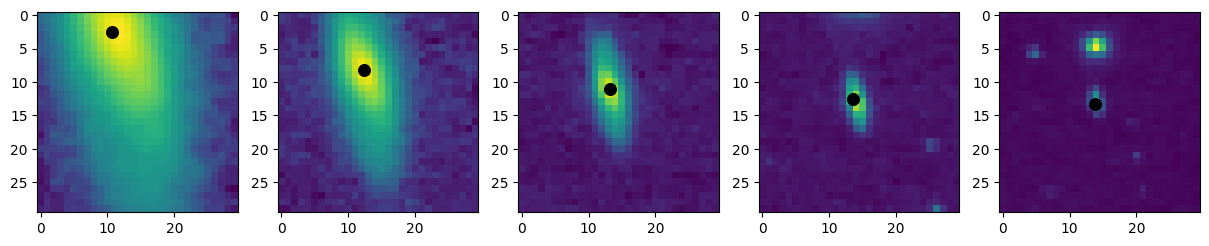

In [73]:
# Realizamos el centrado en la posicion
# 'pos' es la distancia en pixeles de la galaxia a la SN, por lo que para entrenar se ocupa el opuesto (-pos)

recenter_img =  recenter_on_sn(image, pos[::-1])

fig, axs = plt.subplots(1,5, figsize= (15,5))

for i in range(5):
    axs[i].imshow(recenter_img[:,:,i])
    axs[i].scatter((-pos[1]/(2**i) + 14) , (-pos[0]/(2**i) + 14), s=70, color="black") 

plt.show()